# Qiskit Hackathon Global

# NEW METHOD FOR INEQUALITY CONSTRAINED OPTIMIZATION PROBLEM

## The problem

Different optimization problems suited for being solved by quantum computers (QC) have inequality constraints that make the first approach of solving them really difficult for our current noise intermediate-scale quantum (NISQ) technology. This is because the inequality constraints have to be converted into equality constraints which further have to be converted to binary representation and finally is solved with quadratic penalizations. The extra qubits added by these transformations and the resulting equation motivated us to look at alternatives to get rid of the inequality constraints and thus keep the number of qubits constant. We will use the bin packing problem to test our alternatives to the commonly used approach for inequality constrained problems. For the solution, we use the varational quantum algorithm (VQA) quantum approximation optimization algorithm (QAOA). 



## Bin Packing Problem

The [bin packing problem](https://en.wikipedia.org/wiki/Bin_packing_problem) is an optimization problem where given a number of items with different weights, we look at the best way to group the items minimizing the number of bins or containers needed to store them. The restriction, in this case, is thst the bins have a certain capacity and cannot surpass maximum weight. This problem has many real applications in areas as loading trucks with a weight restriction, filling up containers, and FPGA semiconductors chip design. 

In terms of complexity, the bin packing problem is an NP-hard problem. However, there are efficient algorithms that allow the arrangement of a large number of items. One of them is the first fit, which provides a fast but not so optimal solution to the problem. 

For our problem, we will explore the solution of the bin packing problem, using a quantum computing representation in terms of quadratic unconstraint binary optimization (QUBO) and using the quantum approximation optimization (QAOA) algorithm. 

### Problem statement

minimize $$K = \sum_{j=1}^m y_j$$

subject to:

$$\sum_{i=1}^n s(i) x_{ij} \le B y_j \qquad  \forall j=1,...,m$$
$$\sum_{j=1}^m x_{ij} = 1  \qquad \forall i = 1, ..., n$$
$$x_{ij}\in  \{0,1\} \qquad \forall i=1,..,n \qquad j=1,..,m$$
$$y_{j}\in  \{0,1\} \qquad \forall j=1,..,m $$

- n is the number of items
- m is the number of bins
- $s(i)$ is the i-th item weight
- B is the maximum weight of the bin
- $x_{ij}$ is the variable that represent if the item i is in the bin j.
- $y_j$ is the variable that represent if bin j is used

## The solution

We look for a heuristic approach based on a new penalization that does not increase the number of qubits for the solution on a QC and still accomplishes the penalization when the sum of the weights on a bin surpasses the maximum weight allowed. In this notebook, we will go through:

1) Codification of the problem

2) The classical approach

3) Our new approach

4) Comparison between both approaches

5) Conclusions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from docplex.mp.model import Model
from qiskit import BasicAer
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.algorithms.admm_optimizer import ADMMParameters, ADMMOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms.optimizers import COBYLA

## 1. Codification of the problem

To construct the model, we use the library docplex. Once we have the problem as a cplex model, we use the function QuadraticProgram from qiskit_optimization to translate the problem and finally the function QuadraticProgramToQubo to convert the problem into the quadratic unconstrained binary optimization (QUBO) representation.

For this initial set, we chose a small problem. Here, we select 3 items with a maximum weight of 15. The weight of the items is chosen randomly from values between 1 and the maximal weight. 

In [2]:
np.random.seed(1)
num_items = 3 # number of items
num_bins = num_items # maximum number of bins
max_weight = 15# max weight of a bin

weights = np.random.randint(1, max_weight, num_items) # Randomly picking the item weight

In [3]:
# Construct model using docplex
mdl = Model("BinPacking")

y = mdl.binary_var_list(num_bins, name="y") # list of variables that represent the bins
x =  mdl.binary_var_matrix(num_items, num_bins, "x") # variables that represent the items on the specific bin

objective = mdl.sum(y)

mdl.minimize(objective)

for i in range(num_items):
    # First set of constraints: the items must be in any bin
    mdl.add_constraint(mdl.sum(x[i, j] for j in range(num_bins)) == 1)
    
for j in range(num_bins):
    # Second set of constraints: weight constraints
    mdl.add_constraint(mdl.sum(weights[i] * x[i, j] for i in range(num_items)) <= max_weight * y[j])

# Load quadratic program from docplex model
qp = QuadraticProgram()
qp.from_docplex(mdl)
qubo = QuadraticProgramToQubo().convert(qp)# Create a converter from quadratic program to qubo representation

<ipython-input-3-b1653240079c>:21: DeprecationWarning: The from_docplex method is deprecated as of version 0.2.0 and will be removed no sooner than 3 months after the release. Instead use the qiskit_optimization.translators.from_docplex_mp function.
  qp.from_docplex(mdl)


The number of variables prior converting to QUBO is 12
The number of variables after converting to QUBO is 24


Text(0.5, 1.0, 'Num. vars for 3 items')

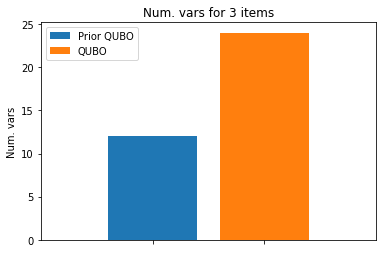

In [4]:
print(f"The number of variables prior converting to QUBO is {qp.get_num_vars()}")
print(f"The number of variables after converting to QUBO is {qubo.get_num_vars()}")

plt.figure()
plt.bar(0, qp.get_num_vars(), label="Prior QUBO")
plt.bar(1, qubo.get_num_vars(), label="QUBO")
plt.xticks(range(2), 2 * [""])
plt.xlim((-1,2))
plt.legend()
plt.ylabel("Num. vars")
plt.title(f"Num. vars for {num_items} items")

### Simplifications

From this point and through the document, we make some simplifications for the problem being easy to solve, the problem variables can be reduced using the following simplifications:

- Removing unnecesary decision variables, the minimum number of bins should be at least equal to the sum of the weights of the items. $l = \mathrm{Int}\left(\frac{\sum_i^n s(i)}{B}\right)$

- We assign the first item into the first bin., $x_{0,0} = 1$

Therefore, the number of variables after the simplifications and assuming $m = n$: 

$$m(n - 1) + (m - l) = (n^2 - l)$$

meanwhile for the original number of variables is:

$$mn+m = n^2 + n$$

a reduction of $(n + l)$ variables.

In [4]:
def BinPacking(num_items, num_bins, weights, max_weight, simplification=False):
    # Construct model using docplex
    mdl = Model("BinPacking")

    y = mdl.binary_var_list(num_bins, name="y") # list of variables that represent the bins
    x =  mdl.binary_var_matrix(num_items, num_bins, "x") # variables that represent the items on the specific bin

    objective = mdl.sum(y)

    mdl.minimize(objective)

    for i in range(num_items):
        # First set of constraints: the items must be in any bin
        mdl.add_constraint(mdl.sum(x[i, j] for j in range(num_bins)) == 1)

    for j in range(num_bins):
        # Second set of constraints: weight constraints
        mdl.add_constraint(mdl.sum(weights[i] * x[i, j] for i in range(num_items)) <= max_weight * y[j])

    # Load quadratic program from docplex model
    qp = QuadraticProgram()
    qp.from_docplex(mdl)
    if simplification:
        l = int(np.ceil(np.sum(weights)/max_weight))
        qp = qp.substitute_variables({f"y_{_}":1 for _ in range(l)}) # First simplification 
        qp = qp.substitute_variables({"x_0_0":1}) # Assign the first item into the first bin
        qp = qp.substitute_variables({f"x_0_{_}":0 for _ in range(1, num_bins)}) # as the first item is in the first 
                                                                                #bin it couldn't be in the other bins
    qubo = QuadraticProgramToQubo().convert(qp)# Create a converter from quadratic program to qubo representation
    return qubo

### Visualization of the number of variables

After the simplification, the number of variables is 18


Text(0.5, 1.0, 'Num. vars for 3 items')

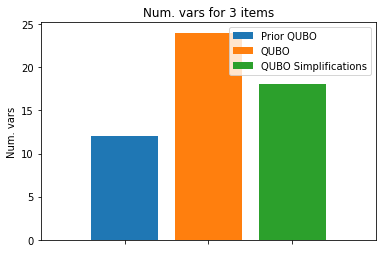

In [6]:
qubo_simp = BinPacking(num_items, num_bins, weights, max_weight, simplification=True)
print(f"After the simplification, the number of variables is {qubo_simp.get_num_vars()}")
plt.figure()
plt.bar(0, qp.get_num_vars(), label="Prior QUBO")
plt.bar(1, qubo.get_num_vars(), label="QUBO")
plt.bar(2, qubo_simp.get_num_vars(), label="QUBO Simplifications")
plt.xticks(range(3), 3 * [""])
plt.xlim((-1,3))
plt.legend()
plt.ylabel("Num. vars")
plt.title(f"Num. vars for {num_items} items")

## 2. The Classical approach: Solution with the QUBO simplication approach and QAOA

Once we have the problem as a QUBO representation, we can solve it using QAOA. In this section, we show the results of the solution of the Bin Packing problem for three items and randomly selected weights.

In [5]:
from qiskit import Aer
backend = Aer.get_backend("qasm_simulator")

### Useful functions
These two functions allow the visualization of the bin packing problem solution

In [6]:
def interpret(results, weights, num_items, num_bins, simplify=False):
    """
    Save the results as a list of list where each sublist represent a bin
    and the sublist elements represent the items weights
    
    Args:
    results: results of the optimization
    weights (list): weights of the items
    num_items: (int) number of items
    num_bins: (int) number of bins
    """
    if simplify:
        l = int(np.ceil(np.sum(weights)/max_weight))
        bins = l * [1] + list(results[:num_bins - l])
        items = results[num_bins - l: (num_bins - l) + num_bins * (num_items - 1)].reshape(num_items - 1, num_bins)
        items_in_bins = [[i+1 for i in range(num_items-1) if bins[j] and items[i, j]] for j in range(num_bins)]
        items_in_bins[0].append(0)
    else:
        bins = results[:num_bins]
        items = results[num_bins:(num_bins + 1) * num_items].reshape((num_items, num_bins))
        items_in_bins = [[i for i in range(num_items) if bins[j] and items[i, j]] for j in range(num_bins)]
    return items_in_bins

def get_figure(items_in_bins, weights, max_weight, title=None):
    """Get plot of the solution of the Bin Packing Problem.

    Args:
        result : The calculated result of the problem

    Returns:
        fig: A plot of the solution, where x and y represent the bins and
        sum of the weights respectively.
    """
    colors = plt.cm.get_cmap("jet", len(weights))
    num_bins = len(items_in_bins)
    fig, axes = plt.subplots()
    for _, bin_i in enumerate(items_in_bins):
        sum_items = 0
        for item in bin_i:
            axes.bar(_, weights[item], bottom=sum_items, label=f"Item {item}", color=colors(item))
            sum_items += weights[item]
    axes.hlines(max_weight, -0.5, num_bins - 0.5, linestyle="--", color="tab:red", label="Max Weight")
    axes.set_xticks(np.arange(num_bins))
    axes.set_xlabel("Bin")
    axes.set_ylabel("Weight")
    axes.legend()
    if title:
        axes.set_title(title)
    return fig

### Solution using QAOA

Here, we test the QAOA solution of the QUBO problem and compare it with the CPLEX solution. For the solution, it sometimes converges and other times it does not. Even so, the QAOA did not converge to the optimal point.

In [9]:
qaoa = MinimumEigenOptimizer(QAOA(reps=3, quantum_instance=backend))
result_qaoa = qaoa.solve(qubo_simp)
print("Solving QUBO using QAOA")
print(result_qaoa)
print("Solving QUBO using CPLEX")
result_ideal = CplexOptimizer().solve(qubo_simp)
print(result_ideal)

Solving QUBO using QAOA
optimal function value: 10.0
optimal value: [0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1.]
status: SUCCESS
Solving QUBO using CPLEX
optimal function value: 3.0
optimal value: [0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.]
status: SUCCESS


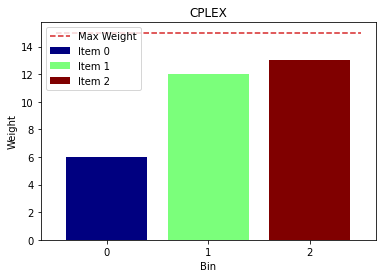

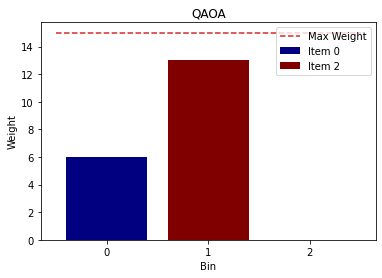

In [10]:
fig = get_figure(interpret(result_ideal.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="CPLEX")
fig = get_figure(interpret(result_qaoa.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="QAOA")

### The increment of the number of qubits with the number of items

As we can see, the usual approach couldn't be even solved if we use more than 5 items, this is because a simulation of the problem will be so expensive, and executing it on a real device is unfeasible because of the noise and the number of qubits in NISQ devices.

The number of qubits is: {2: 9, 3: 17, 4: 30, 5: 38, 6: 57, 7: 71, 8: 90, 9: 111}


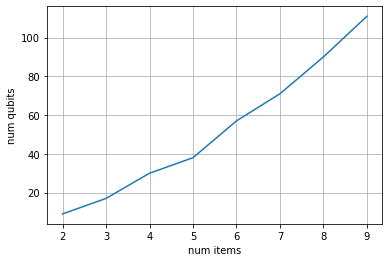

In [11]:
max_weight = 15
num_qubits = {}
for i in range(2, 10):
    num_items = i
    num_bins = num_items
    weights = [np.random.randint(1, max_weight) for _ in range(i)]
    num_qubits[i] = BinPacking(num_items, num_bins, weights, max_weight, simplification=True).get_num_vars()

plt.figure()
plt.plot(num_qubits.keys(), num_qubits.values())
plt.xlabel("num items")
plt.ylabel("num qubits")
plt.grid()
print(f"The number of qubits is: {num_qubits}")

## 2. Our New approach: A Heuristic method to solve inequality constrained optimization problems

As we see above, translating the inequality constraints to equality constraints and binary representation has a large cost in terms of qubits. Therefore, we want to propose a new method that does not involve the use of more qubits than those needed to represent the bins and the items into the bins. Then, we need a penalization term that adds a large penality when the sum of weights of the items in a bin is greater than the maximum weight. We realize it with an exponential function of the form:

$$f(x) = e^{-t}$$

However, we can not represent the exponential function using QUBOs. What we use is an approximation of the exponential to the second-order that is the maximum order for a QUBO: 

$$f(x) = e^{-t} \approx 1 - t + t^2/2$$



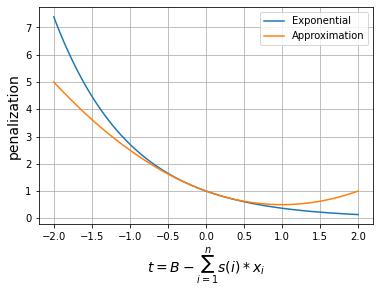

In [7]:
x = np.linspace(-2, 2, 100)
plt.figure()
plt.plot(x, np.exp(-x), label="Exponential")
plt.plot(x, 1 - (x) + (x) ** 2 / 2, label="Approximation")
plt.xlabel(r"$t = B - \sum_{i=1}^n s(i)*x_i$", fontsize=14)
plt.ylabel("penalization", fontsize=14)
plt.grid()
plt.legend()

### The new objective

Now, we can represent the inequality constraint using the new approach mention above:

$$\underset{y_j}{minimize}\sum_{j=1}^m y_j + \alpha\left[1 - t + t^2/2\right]$$

where $t = \sum_{j=1}^{m}\left(B y_j -\sum_{i=1}^n s(i)x_{ij}\right)$, we do not need the 1 in front of $t$ because is just a constant. Then, it reduce to:

$$\underset{y_j}{minimize}\sum_{j=1}^m y_j + \alpha\left[-\sum_{j=1}^{m}\left(B y_j -\sum_{i=1}^n s(i)x_{ij}\right) + \frac{\left(\sum_{j=1}^{m}\left( B y_j -\sum_{i=1}^n s(i) x_{ij}\right)\right)^2}{2}\right]$$

where $\alpha$ is a Lagrange multiplier that adjust the penalization to be proportional to the objective function and we must set it. 

In [8]:
def BinPackingNewApproach(num_items, num_bins, weights, max_weight, alpha=0.01, simplification=False):
    # Construct model using docplex
    mdl = Model("BinPackingNewApproach")

    y = mdl.binary_var_list(num_bins, name="y") # list of variables that represent the bins
    x =  mdl.binary_var_matrix(num_items, num_bins, "x") # variables that represent the items on the specific bin

    objective = mdl.sum(y)
    
    # PENALIZATION
    penalization = 0
    for j in range(num_bins):
        t = max_weight * y[j] - mdl.sum(weights[i] * x[i, j] for i in range(num_items))
        penalization += -t + t**2 / 2
    mdl.minimize(objective + alpha * penalization)

    for i in range(num_items):
        # First set of constraints: the items must be in any bin
        mdl.add_constraint(mdl.sum(x[i, j] for j in range(num_bins)) == 1)

    # Load quadratic program from docplex model
    qp = QuadraticProgram()
    qp.from_docplex(mdl)
    if simplification:
        l = int(np.ceil(np.sum(weights)/max_weight))
        qp = qp.substitute_variables({f"y_{_}":1 for _ in range(l)}) # First simplification 
        qp = qp.substitute_variables({"x_0_0":1}) # Assign the first item into the first bin
        qp = qp.substitute_variables({f"x_0_{_}":0 for _ in range(1, num_bins)}) # as the first item is in the first 
                                                                                #bin it couldn't be in the other bins
    qubo = QuadraticProgramToQubo().convert(qp)# Create a converter from quadratic program to qubo representation
    return qubo

The number of qubits for the Classical approach is: {2: 9, 3: 19, 4: 29, 5: 43, 6: 55, 7: 74, 8: 90, 9: 110}
The number of qubits is for the new approach is:    {2: 2, 3: 7, 4: 14, 5: 23, 6: 32, 7: 46, 8: 59, 9: 75}


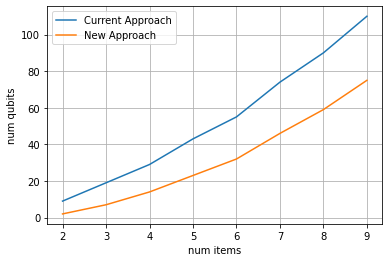

In [14]:
max_weight = 15
num_qubits = {}
num_qubits_new = {}
for i in range(2, 10):
    num_items = i
    num_bins = num_items
    weights = [np.random.randint(1, max_weight) for _ in range(i)]
    num_qubits[i] = BinPacking(num_items, num_bins, weights, max_weight, simplification=True).get_num_vars()
    num_qubits_new[i] = BinPackingNewApproach(num_items, num_bins, weights, max_weight, simplification=True).get_num_vars()
    
plt.figure()
plt.plot(num_qubits.keys(), num_qubits.values(), label="Current Approach")
plt.plot(num_qubits_new.keys(), num_qubits_new.values(), label="New Approach")
plt.xlabel("num items")
plt.ylabel("num qubits")
plt.grid()
plt.legend()
print(f"The number of qubits for the Classical approach is: {num_qubits}")
print(f"The number of qubits is for the new approach is:    {num_qubits_new}")



In [15]:
np.random.seed(1)
num_items = 3 # number of items
num_bins = num_items # maximum number of bins
max_weight = 15 # max weight of a bin
weights = np.random.randint(1, max_weight, num_items) # Randomly picking the item weight


qubo_old = BinPacking(num_items, num_bins, weights, max_weight, simplification=True)
qubo_new = BinPackingNewApproach(num_items, num_bins, weights, max_weight, alpha=0.05, simplification=True)
qaoa = MinimumEigenOptimizer(QAOA(optimizer=COBYLA(maxiter=100), reps=3, quantum_instance=backend))
result_qaoa_old = qaoa.solve(qubo_old)
result_qaoa_new = qaoa.solve(qubo_new)
result_ideal_old = CplexOptimizer().solve(qubo_old)

In [16]:
print("Solving QUBO using QAOA Classical Approach")
print(result_qaoa_old)
print("Solving QUBO using QAOA New Approach")
print(result_qaoa_new)
print("Solving QUBO using CPLEX")
print(result_ideal_old)

Solving QUBO using QAOA Classical Approach
optimal function value: 5.0
optimal value: [0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1.]
status: SUCCESS
Solving QUBO using QAOA New Approach
optimal function value: 4.649999999999977
optimal value: [0. 0. 1. 0. 1. 0.]
status: SUCCESS
Solving QUBO using CPLEX
optimal function value: 3.0
optimal value: [0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0.]
status: SUCCESS


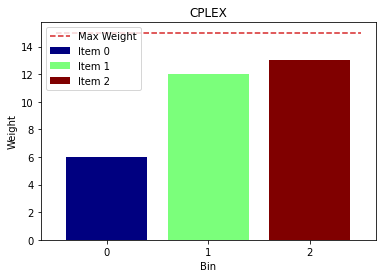

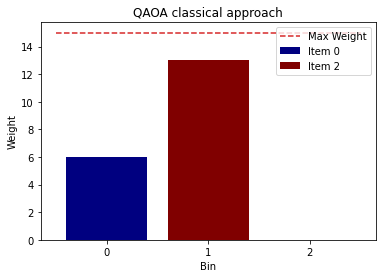

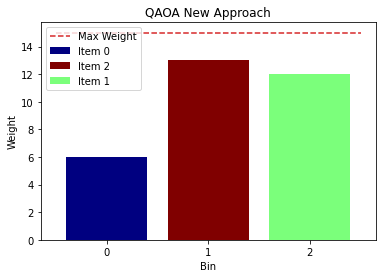

In [17]:
fig = get_figure(interpret(result_ideal_old.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="CPLEX")
fig = get_figure(interpret(result_qaoa_old.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="QAOA classical approach")
fig = get_figure(interpret(result_qaoa_new.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="QAOA New Approach")

In [18]:
#for 3 bins #max weight 15
solutions_new = []
solutions_old = []
solutions_ideal=[]

for _ in range(10):
    result_qaoa_new = qaoa.solve(qubo_new)
    result_qaoa_old = qaoa.solve(qubo_old)
    result_qaoa_ideal=CplexOptimizer().solve(qubo_old)
    solutions_new.append(result_qaoa_new.fval)
    solutions_old.append(result_qaoa_old.fval)
    solutions_ideal.append(result_qaoa_ideal.fval)

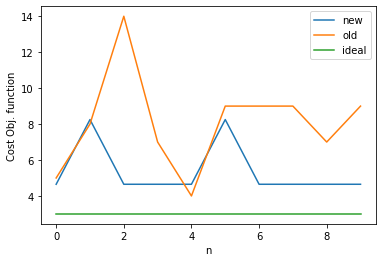

In [19]:
plt.figure()
plt.plot(solutions_new, label="new")
plt.plot(solutions_old, label="old")
plt.plot(solutions_ideal, label="ideal")
plt.xlabel("n")
plt.ylabel("Cost Obj. function")
plt.legend()

In [20]:
#for 3 bins #max weight 15
solutions_new = []
solutions_old = []

for _ in range(10):
    result_qaoa_new = qaoa.solve(qubo_new)
    result_qaoa_old = qaoa.solve(qubo_old)
    solutions_new.append(result_qaoa_new.fval)
    solutions_old.append(result_qaoa_old.fval)

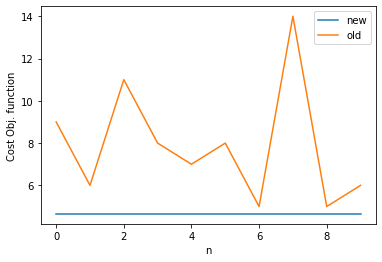

In [21]:
plt.figure()
plt.plot(solutions_new, label="new")
plt.plot(solutions_old, label="old")
plt.xlabel("n")
plt.ylabel("Cost Obj. function")
plt.legend()

In [22]:
#3 bins # max weigth 15
solutions_new = []
solutions_old = []
solutions_ideal=[]

for _ in range(10):
    result_qaoa_new = qaoa.solve(qubo_new)
    result_qaoa_old = qaoa.solve(qubo_old)
    result_qaoa_ideal=CplexOptimizer().solve(qubo_old)
    solutions_new.append(result_qaoa_new.fval)
    solutions_old.append(result_qaoa_old.fval)
    solutions_ideal.append(result_qaoa_ideal.fval)

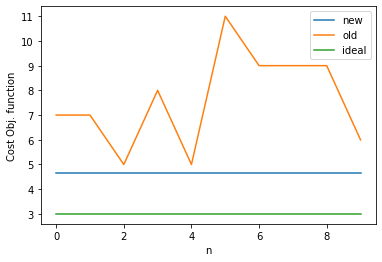

In [23]:
plt.figure()
plt.plot(solutions_new, label="new")
plt.plot(solutions_old, label="old")
plt.plot(solutions_ideal, label="ideal")
plt.xlabel("n")
plt.ylabel("Cost Obj. function")
plt.legend()

# Solution for maximum bins = 3 and maximum weight = 40


The number of qubits for the Classical approach is: {2: 14, 3: 26, 4: 38, 5: 52, 6: 68, 7: 86, 8: 109, 9: 131}
The number of qubits is for the new approach is:    {2: 3, 3: 8, 4: 15, 5: 22, 6: 33, 7: 45, 8: 61, 9: 78}


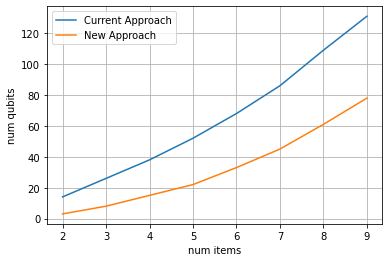

In [9]:
max_weight = 40
num_qubits = {}
num_qubits_new = {}
for i in range(2, 10):
    num_items = i
    num_bins = num_items
    weights = [np.random.randint(1, max_weight) for _ in range(i)]
    num_qubits[i] = BinPacking(num_items, num_bins, weights, max_weight, simplification=True).get_num_vars()
    num_qubits_new[i] = BinPackingNewApproach(num_items, num_bins, weights, max_weight, simplification=True).get_num_vars()
    
plt.figure()
plt.plot(num_qubits.keys(), num_qubits.values(), label="Current Approach")
plt.plot(num_qubits_new.keys(), num_qubits_new.values(), label="New Approach")
plt.xlabel("num items")
plt.ylabel("num qubits")
plt.grid()
plt.legend()
print(f"The number of qubits for the Classical approach is: {num_qubits}")
print(f"The number of qubits is for the new approach is:    {num_qubits_new}")



In [10]:
np.random.seed(1)
num_items = 3 # number of items
num_bins = num_items # maximum number of bins
max_weight = 40 # max weight of a bin
weights = np.random.randint(1, max_weight, num_items) # Randomly picking the item weight


qubo_old = BinPacking(num_items, num_bins, weights, max_weight, simplification=True)
qubo_new = BinPackingNewApproach(num_items, num_bins, weights, max_weight, alpha=0.05, simplification=True)
qaoa = MinimumEigenOptimizer(QAOA(optimizer=COBYLA(maxiter=100), reps=3, quantum_instance=backend))
result_qaoa_old = qaoa.solve(qubo_old)
result_qaoa_new = qaoa.solve(qubo_new)
result_ideal_old = CplexOptimizer().solve(qubo_old)

In [11]:
print("Solving QUBO using QAOA Classical Approach")
print(result_qaoa_old)
print("Solving QUBO using QAOA New Approach")
print(result_qaoa_new)
print("Solving QUBO using CPLEX")
print(result_ideal_old)

Solving QUBO using QAOA Classical Approach
optimal function value: 7.0
optimal value: [1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1.]
status: SUCCESS
Solving QUBO using QAOA New Approach
optimal function value: 9.199999999999989
optimal value: [0. 0. 1. 0. 0. 1. 0.]
status: SUCCESS
Solving QUBO using CPLEX
optimal function value: 2.0
optimal value: [0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
status: SUCCESS


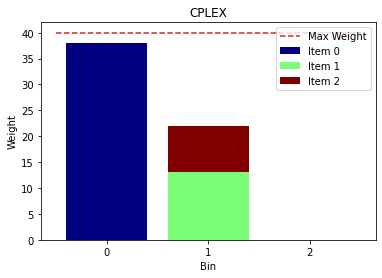

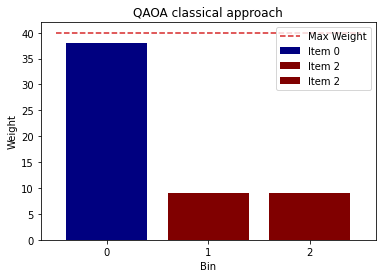

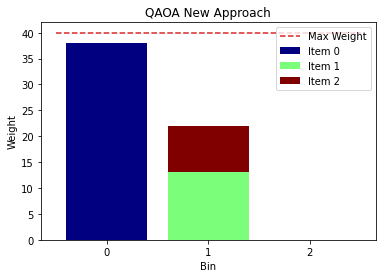

In [12]:
fig = get_figure(interpret(result_ideal_old.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="CPLEX")
fig = get_figure(interpret(result_qaoa_old.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="QAOA classical approach")
fig = get_figure(interpret(result_qaoa_new.x, weights, num_items, num_bins, simplify=True), weights, max_weight, title="QAOA New Approach")

In [13]:
#3 bins # max weight 40
solutions_new = []
solutions_old = []
solutions_ideal=[]

for _ in range(10):
    result_qaoa_new = qaoa.solve(qubo_new)
    result_qaoa_old = qaoa.solve(qubo_old)
    result_qaoa_ideal=CplexOptimizer().solve(qubo_old)
    solutions_new.append(result_qaoa_new.fval)
    solutions_old.append(result_qaoa_old.fval)
    solutions_ideal.append(result_qaoa_ideal.fval)

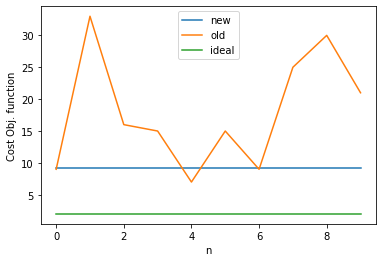

In [14]:
plt.figure()
plt.plot(solutions_new, label="new")
plt.plot(solutions_old, label="old")
plt.plot(solutions_ideal, label="ideal")
plt.xlabel("n")
plt.ylabel("Cost Obj. function")
plt.legend()